## Goals: Feature Engineering

This notebook merge *Brazil* and *France* dataset into a single training dataset.
It adds seasonal information (seasons, month), scale relevent features and removed unecessary columns.

> Note this notebook need ouputs from both *01a - Data Preprocessing Brazil* and 01b - *Data Preprocessing France*

![Alt text](../images/notebook-2.png)

### 1. Data Import and Setup

Imports necessary libraries, sets up environment paths, and includes custom utility functions.



In [1]:
import sys
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))
sys.path.append(BASE_DIR)

from src.utils.plots import plot_water_flows

Defines constants :
* INPUT_DIR must be the same as the one defined in *01 - Data Preprocessing* notebook.
* EVAL_DIR must be the same as the one defined in *01 - Data Preprocessing* notebook.

In [2]:
#replace with your directory

INPUT_DIR = "/N/lustre/project/proj-212/Ramtelpp/PersonalProject/Coda/data/input/"
EVAL_DIR = "/N/lustre/project/proj-212/Ramtelpp/PersonalProject/Coda/data/evaluation/"

datasets = { "train": INPUT_DIR, "eval" : EVAL_DIR}


### 2. Data Loading and Initial Cleaning

* Reads in the French and Brazilian baseline datasets, removes unnecessary columns, and sets the date as the index.
* Introduces a binary indicator (`north_hemisphere`) to distinguish between data from France and Brazil.
* Merges the French and Brazilian datasets into a single DataFrame for further processing.

In [3]:
dataset_baseline = {}

for set, dir in datasets.items():
    path_data_baseline_france = f"{dir}preprocessed_france.csv"
    dataset_baseline_france = pd.read_csv(path_data_baseline_france)

    dataset_baseline_france = dataset_baseline_france.iloc[:,1:]
    dataset_baseline_france = dataset_baseline_france.drop(columns=["index"])


    dataset_baseline_france = (
        dataset_baseline_france
        .set_index("ObsDate")
    )

    path_data_baseline = f"{dir}preprocessed_brazil.csv"
    dataset_baseline_brazil = pd.read_csv(path_data_baseline)

    # remove the first column
    dataset_baseline_brazil = dataset_baseline_brazil.iloc[:,1:]
    dataset_baseline_brazil = dataset_baseline_brazil.drop(columns=["index"])

    dataset_baseline_brazil = (
        dataset_baseline_brazil
        .set_index("ObsDate")
    )


    dataset_baseline_france["north_hemisphere"] = 1
    dataset_baseline_brazil["north_hemisphere"] = 0

    dataset_baseline[set] = pd.concat([dataset_baseline_france, dataset_baseline_brazil], axis=0)

### 3. Feature Engineering

Creates seasonal and monthly indicator columns.


In [4]:
for set, dir in datasets.items():
    # Convert the index to datetime and extract the month
    month = pd.to_datetime(dataset_baseline[set].index).month

    # Define season mappings
    seasons = {
        "is_winter": [1, 2, 3],
        "is_spring": [4, 5, 6],
        "is_summer": [7, 8, 9],
        "is_autumn": [10, 11, 12],
    }

    # Apply season flags
    for season, months in seasons.items():
        dataset_baseline[set][season] = month.isin(months)

    # Define month abbreviations and apply monthly flags
    months_abbr = ["jan", "feb", "mar", "apr", "may", "jun",
                "jul", "aug", "sep", "oct", "nov", "dec"]
    for i, abbr in enumerate(months_abbr, start=1):
        dataset_baseline[set][f"is_{abbr}"] = month == i

Applies MinMax scaling to the selected features.

In [8]:
for set, dir in datasets.items():
    scaler = MinMaxScaler()
    cols = dataset_baseline[set].columns
    # remove the water_flows columns
    if set == "eval":
        cols = cols.drop(["station_code", "water_flow_lag_1w", "water_flow_lag_2w"])
    elif set == "train":
        cols = cols.drop(["water_flow_week1", "station_code", "water_flow_week2", "water_flow_week3", "water_flow_week4", "water_flow_lag_1w", "water_flow_lag_2w"])
    dataset_baseline[set][cols] = scaler.fit_transform(dataset_baseline[set][cols])

### 4. Handling Missing Data

Removes undesired columns, identifies columns with missing values, and imputes them with their respective column means.


In [9]:
# remove columns that start with index_
for set, dir in datasets.items():
    cols = dataset_baseline[set].columns
    cols = cols[~cols.str.startswith("index_")]
    dataset_baseline[set] = dataset_baseline[set][cols]

    # find columns that contains nan values

    cols_nan = dataset_baseline[set].columns[dataset_baseline[set].isna().any()].tolist()

    # impute nan values with the mean
    for col in cols_nan:
        dataset_baseline[set][col] = dataset_baseline[set][col].fillna(dataset_baseline[set][col].mean())

### 5. Data Saving, and Visualization

Saves the complete baseline.

In [16]:
for set, dir in datasets.items():
    dataset_baseline[set].to_csv(f"{dir}dataset_baseline.csv")

In [17]:
f"{dir}dataset_baseline.csv"

'/N/lustre/project/proj-212/Ramtelpp/PersonalProject/Coda/data/evaluation/dataset_baseline.csv'

Visualizes the water flow for the 10 first stations.

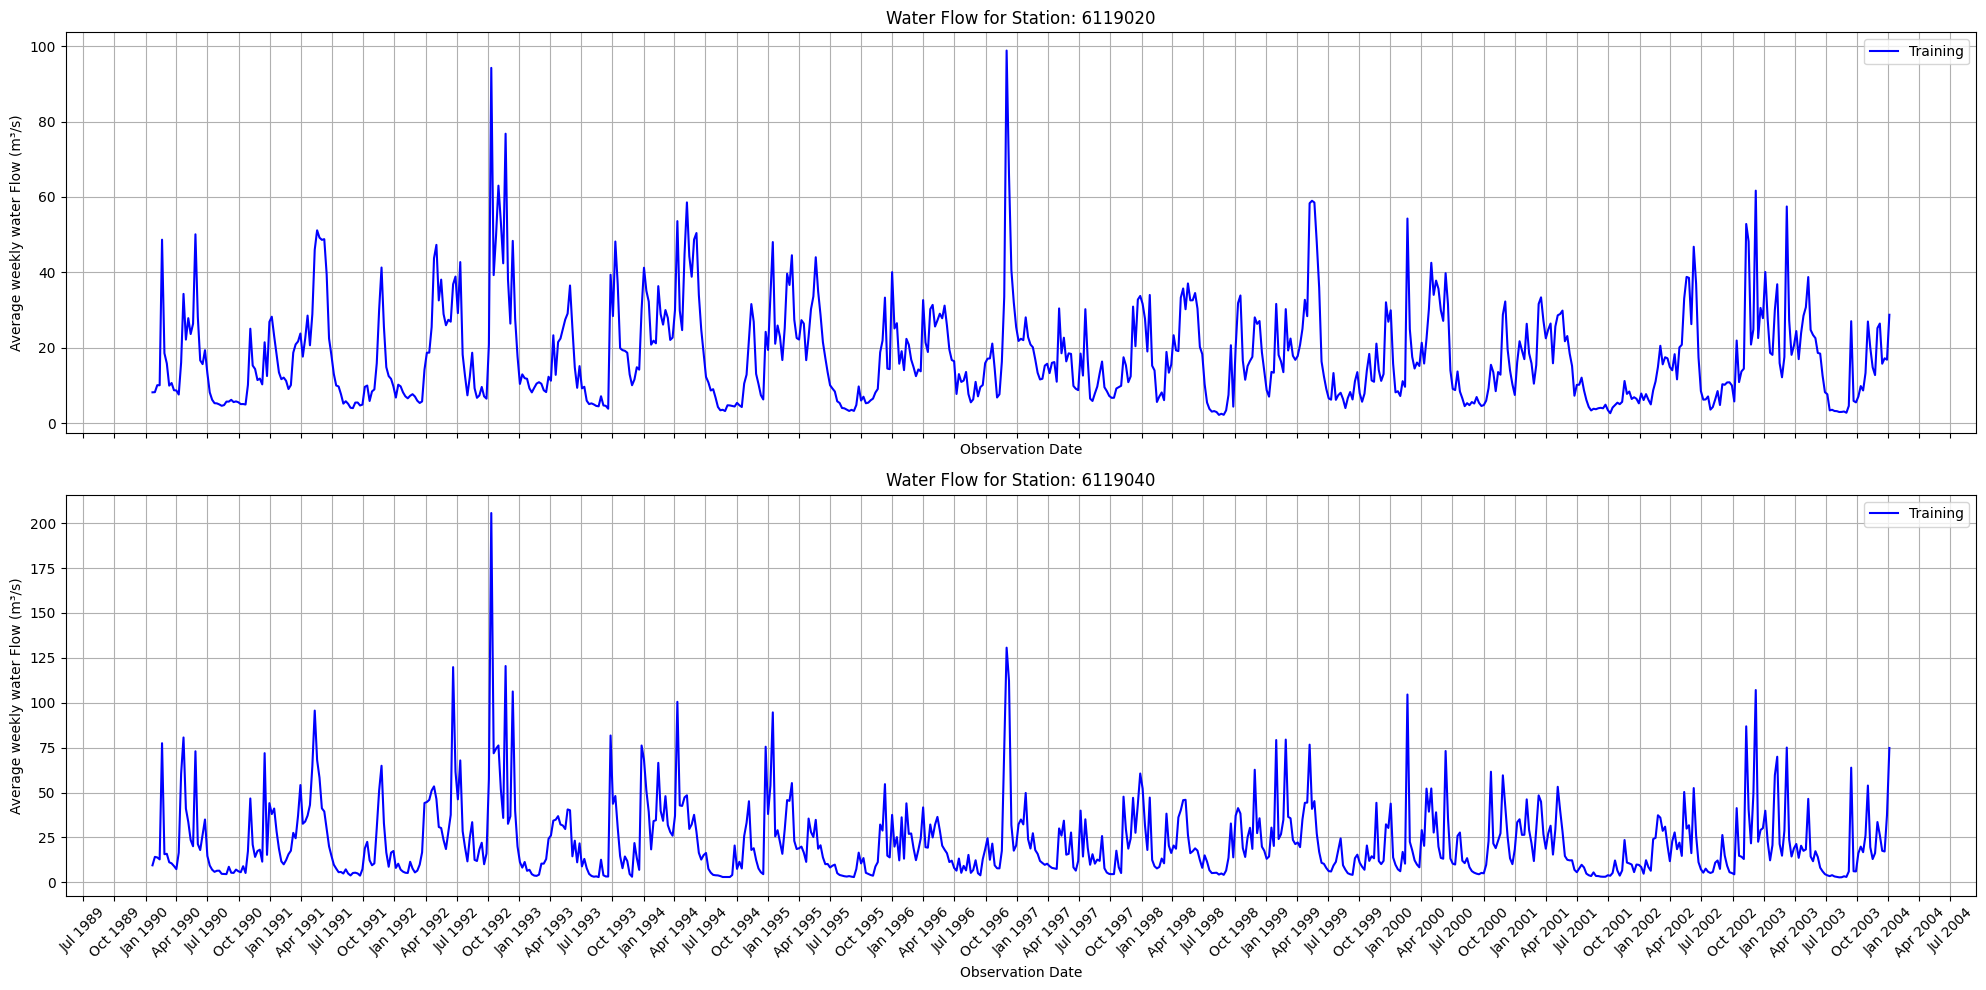

In [8]:
plot_water_flows(dataset_baseline["train"], max_stations = 2, display = True, save = False)